In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%%time
df = pd.read_csv(
    './data/train.csv', nrows=1e5,
    parse_dates=['click_time', 'attributed_time']
)

CPU times: user 205 ms, sys: 24.1 ms, total: 230 ms
Wall time: 239 ms


In [4]:
df['day'] = df['click_time'].dt.day
df['hour'] = df['click_time'].dt.hour

In [31]:
df_temp = df.groupby(['ip', 'day', 'hour']).count()['app']
df_temp = df_temp.reset_index().rename(columns={'app' : 'ipxdayxhour_count'})
df_temp

,ip,day,hour,ipxdayxhour_count
0,31,6,16,6
1,36,6,16,3
2,60,6,16,1
3,81,6,16,12
4,92,6,16,5
5,95,6,16,3
6,122,6,16,1
7,126,6,16,1
8,151,6,16,1
9,169,6,16,1


In [32]:
df_temp['ipxdayxhour_count'].describe()

count    15588.000000
mean         6.415191
std         13.249143
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max        610.000000
Name: ipxdayxhour_count, dtype: float64

In [33]:
df_more = df.merge(df_temp, how='outer', on=['ip', 'hour'])
df_more['ipxdayxhour_count'].describe()

count    100000.000000
mean         33.776580
std          80.221957
min           1.000000
25%           6.000000
50%          12.000000
75%          23.000000
max         610.000000
Name: ipxdayxhour_count, dtype: float64

/Users/shandou/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


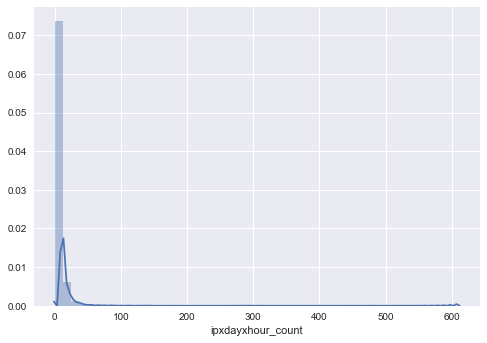

In [34]:
import seaborn as sns
fig, ax = plt.subplots()
sns.distplot(df_temp['ipxdayxhour_count'], ax=ax)
plt.show();